# Import Libraries

In [32]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from art.estimators.classification import KerasClassifier
from art.attacks.inference.model_inversion.mi_face import MIFace
tf.compat.v1.disable_eager_execution()

# Load Dataset

In [33]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [34]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [35]:
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

In [36]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [37]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    
    Dense(128, activation="relu"),
    Dense(10, activation="softmax")
])

In [38]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
classifier = KerasClassifier(model=model, clip_values=(0, 1), use_logits=False)

In [41]:
classifier.fit(x_train, y_train, nb_epochs=10, batch_size=128)

Train on 60000 samples
Epoch 1/10


2023-08-20 21:00:35.531992: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-20 21:00:35.532479: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-08-20 21:00:35.550185: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-08-20 21:00:35.584107: W tensorflow/c/c_api.cc:300] Operation '{name:'training/Adam/dense/bias/v/Assign' id:423 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense/bias/v/Assign}} = AssignVariableOp[_has_manual

60000/60000 [==============================] - 17s 291us/sample - loss: 0.4888 - accuracy: 0.8261
Epoch 2/10
60000/60000 [==============================] - 17s 289us/sample - loss: 0.3118 - accuracy: 0.8888
Epoch 3/10
60000/60000 [==============================] - 18s 303us/sample - loss: 0.2672 - accuracy: 0.9030
Epoch 4/10
60000/60000 [==============================] - 17s 287us/sample - loss: 0.2393 - accuracy: 0.9122
Epoch 5/10
60000/60000 [==============================] - 17s 288us/sample - loss: 0.2162 - accuracy: 0.9215
Epoch 6/10
60000/60000 [==============================] - 17s 288us/sample - loss: 0.1939 - accuracy: 0.9289
Epoch 7/10
60000/60000 [==============================] - 21s 358us/sample - loss: 0.1751 - accuracy: 0.9352
Epoch 8/10
60000/60000 [==============================] - 19s 310us/sample - loss: 0.1597 - accuracy: 0.9413
Epoch 9/10
60000/60000 [==============================] - 18s 302us/sample - loss: 0.1437 - accuracy: 0.9474
Epoch 10/10
60000/60000 [=====

# Attack

In [42]:
attack = MIFace(classifier, max_iter=10000, threshold=1.0)

In [43]:
y = np.arange(10)

In [44]:
classes = {
    0: 'T-shirt/top', 
    1: 'Trouser', 
    2: 'Pullover', 
    3: 'Dress', 
    4: 'Coat', 
    5: 'Sandal', 
    6: 'Shirt', 
    7: 'Sneaker', 
    8: 'Bag', 
    9: 'Ankle-boot'
}

In [45]:
avg = np.zeros((10, 28, 28, 1)) + np.mean(x_test, axis=0)

In [48]:
infer_avg = attack.infer(avg, y)

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

/home/alper/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-20 21:27:04.369449: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1/Softmax' id:102 op device:{requested: '', assigned: ''} def:{{{node dense_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


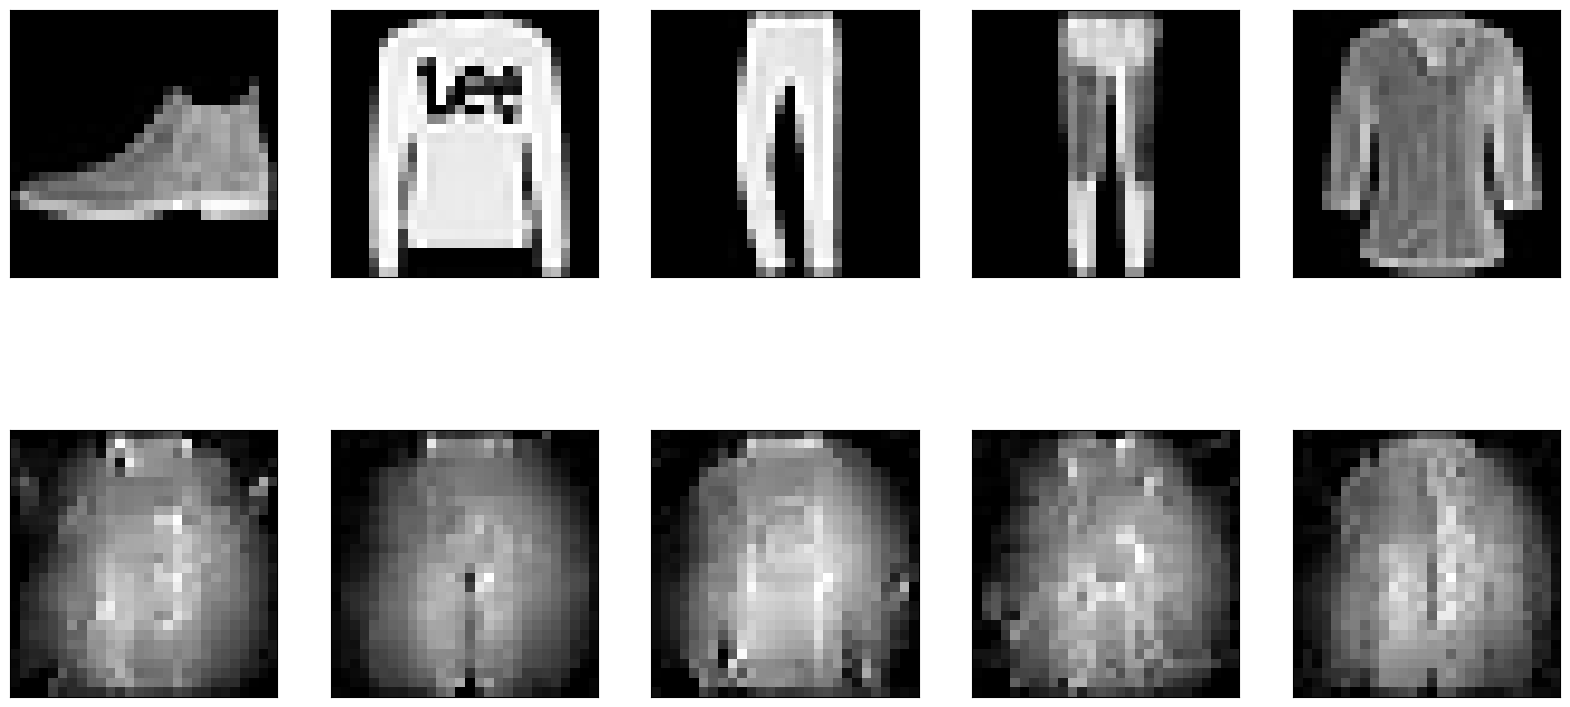

In [49]:
plt.figure(figsize=(20, 10))

for i in range(5):
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(x_test[i,], cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, 5, i+1+5)
    plt.imshow((np.reshape(infer_avg[i,], (28, 28))), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [50]:
pred_true = classifier.predict(x_test)

In [52]:
acc_true = np.sum(np.argmax(pred_true, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("TRUE: ", acc_true)

TRUE:  0.9192


In [56]:
pred_adv = classifier.predict(infer_avg)

In [58]:
acc_adv = np.sum(np.argmax(pred_adv, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("adv: ", acc_adv)

adv:  0.0


/tmp/ipykernel_25569/355926233.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  acc_adv = np.sum(np.argmax(pred_adv, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)


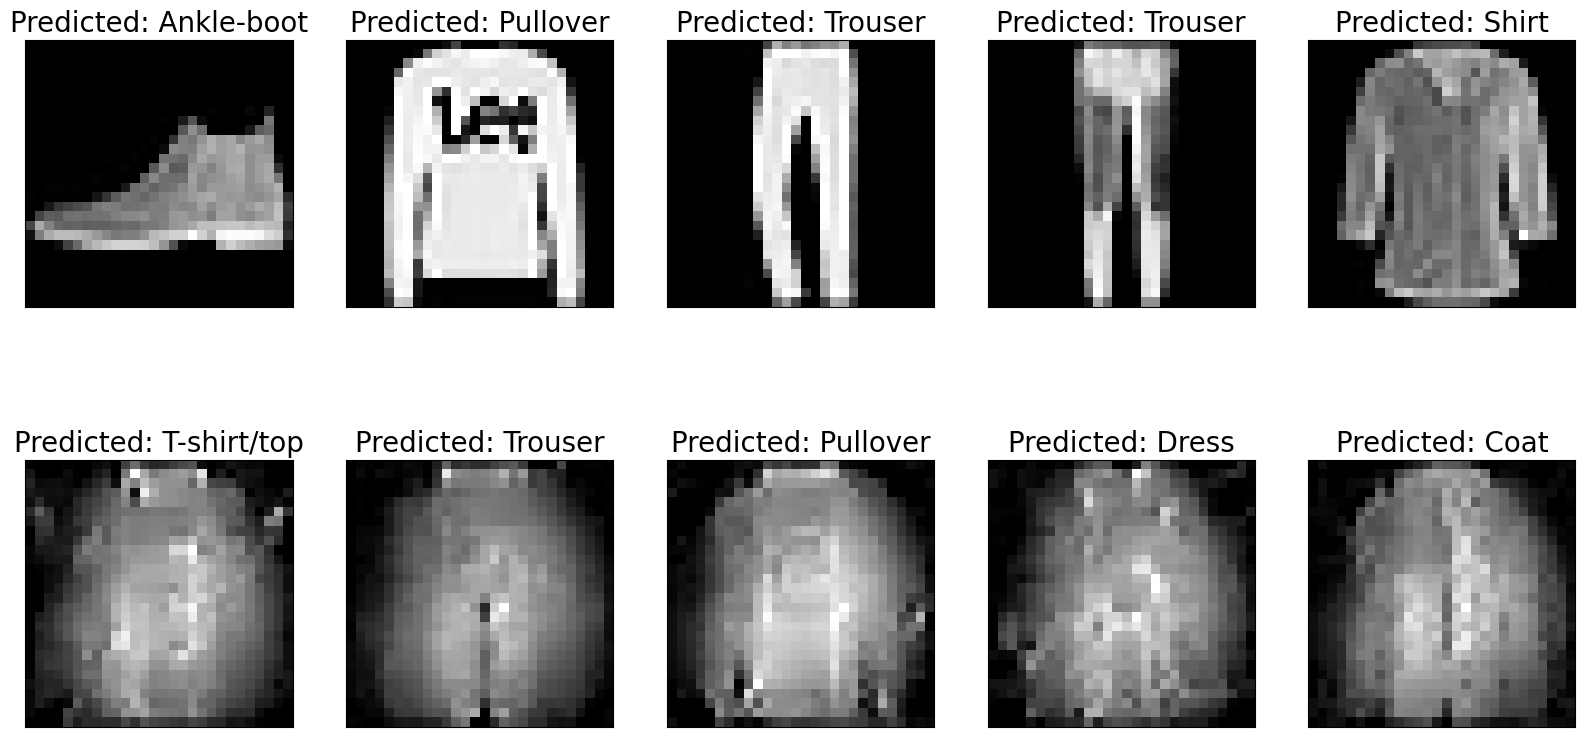

In [60]:
plt.figure(figsize=(20, 10))

for i in range(5):
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(x_test[i,], cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Predicted: {classes.get(pred_true[i].argmax())}", fontsize=20)
    
    ax = plt.subplot(2, 5, i+1+5)
    plt.imshow((np.reshape(infer_avg[i,], (28, 28))), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Predicted: {classes.get(pred_adv[i].argmax())}", fontsize=20)
    
plt.show()